## Comparing Strain Sensor on Index MCP to time

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import path_to_repository
from analysis import DLC3DBendAngles
from analysis import bender_class
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
renc = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_rotenc_2025_09_09_11_48_41.csv")
strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_11_48_41_C/data_adc_2025_09_09_11_48_41.csv")
h_strain = os.path.join(path_to_repository , "CSV Data/9_9_25/2025_09_09_13_01_26_B/data_adc_2025_09_09_13_01_26.csv")

strain_df = pd.read_csv(strain)




# --- load CSVs ---
strain_df = pd.read_csv(strain)
h_strain_df = pd.read_csv(h_strain)


cam = DLC3DBendAngles(strain_df)
h_cam = DLC3DBendAngles(h_strain_df)

In [5]:
cam = DLC3DBendAngles(h_strain)
cam.df

,timestamp,adc_ch0,adc_ch1,adc_ch2,adc_ch3
,130127708258,0,0,0,12919905
,130127708258,0,0,0,12922635
0,130127708258,0,0,0,12927755
1,130127708258,0,0,0,12929633
2,130127708258,0,0,0,12932363
3,130127729093,3892,0,0,12925537
4,130127729093,0,0,0,12925707
...,...,...,...,...,...
6958,130137705613,0,0,0,12910347
6959,130137705613,0,0,0,12923659


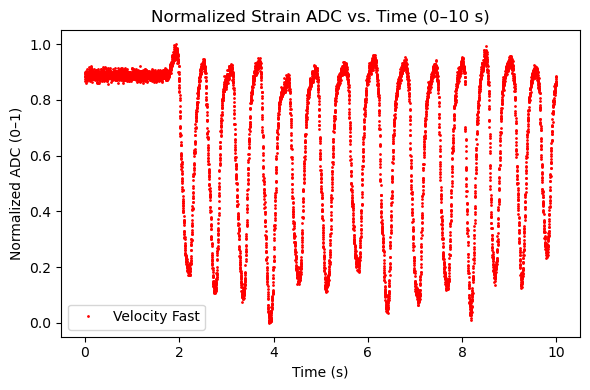

In [6]:
dfs = [strain_df]
labels = ["Velocity Fast"]
colors = ["red"]

plt.figure(figsize=(6,4))

for df, lbl, c in zip(dfs, labels, colors):
    # Number of rows
    n = len(df)

    # Time axis from 0 to 10 sec
    x = np.linspace(0, 10, n)

    # Convert column to numeric
    y = pd.to_numeric(df["adc_ch3"], errors="coerce")
    mask = y.notna()

    # Normalize to 0–1
    y_valid = y[mask]
    y_norm = (y_valid - y_valid.min()) / (y_valid.max() - y_valid.min())

    plt.plot(x[mask],
             y_norm,
             ".", markersize=2, color=c, label=lbl)

plt.xlabel("Time (s)")
plt.ylabel("Normalized ADC (0–1)")
plt.title("Normalized Strain ADC vs. Time (0–10 s)")
plt.legend()
plt.tight_layout()
plt.show()


Loaded merged_df with 6965 rows into bender_class.
ADC normalized bw 0-1. ADC max:  1.0 ADC min:  0.0


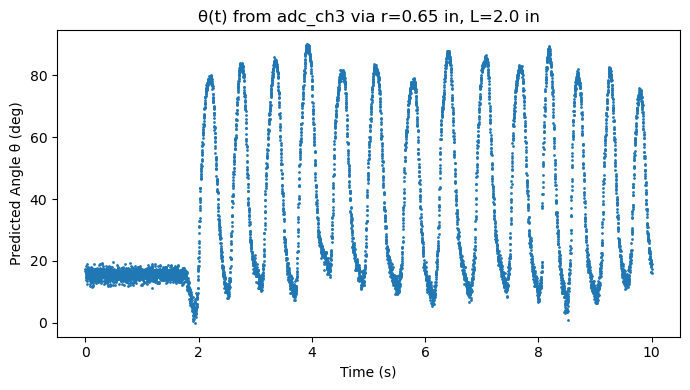

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Ensure a dummy encoder column so load_merged_df works ---
if "angle_renc" not in strain_df.columns:
    strain_df = strain_df.copy()
    strain_df["angle_renc"] = 0.0  # placeholder, not used

# --- 2) Load, normalize, and invert to theta (deg) ---
h = bender_class()
h.load_merged_df(strain_df, enc_col="angle_renc", adc_col="adc_ch3")
h.normalize_adc_bw_01()  # writes into h.data["ADC Value"] in [0,1]

# Heuristic to decide flipping so that 0°→0 and 90°→1 (same convention as autobender)
adc = h.data["ADC Value"].to_numpy(dtype=float)
n = len(adc)
q = max(1, n // 20)               # ~5% window
adc_at_start = float(np.nanmean(adc[:q]))
adc_at_end   = float(np.nanmean(adc[-q:]))
flip_needed  = (adc_at_end < adc_at_start)

# Compute theta for each sample using your theoretical model inversion
# (r=0.65", L=2.0"). If your local method doesn't accept tol_deg/max_iters, drop them.
h.append_theta_from_normalized(
    r_hand=0.65,
    L=2.0,
    value_col="ADC Value",
    out_col="theta_pred_deg",
    flip_data=flip_needed,
    tol_deg=1e-3,
    max_iters=30
)

# --- 3) Make a synthetic time axis from 0 to 10 s ---
t = np.linspace(0, 10, len(h.data))

# Keep only finite rows (in case any NaNs snuck in)
theta = np.asarray(h.data["theta_pred_deg"], dtype=float)
mask = np.isfinite(theta)
t_plot = t[mask]
theta_plot = theta[mask]

# --- 4) Plot θ vs time ---
plt.figure(figsize=(7,4))
plt.plot(t_plot, theta_plot, ".", markersize=2)
plt.xlabel("Time (s)")
plt.ylabel("Predicted Angle θ (deg)")
plt.title("θ(t) from adc_ch3 via r=0.65 in, L=2.0 in")
plt.tight_layout()
plt.show()


In [22]:
h.data

,Rotary Encoder,ADC Value,C3,C4,theta_pred_deg
0,0.0,0.875270,0,0,17.342949
1,0.0,0.881020,0,0,16.607552
2,0.0,0.891804,0,0,15.212288
3,0.0,0.895760,0,0,14.695930
4,0.0,0.901510,0,0,13.939934
...,...,...,...,...,...
6960,0.0,0.855139,0,0,19.875298
6961,0.0,0.883177,0,0,16.330147
6962,0.0,0.886054,0,0,15.958672
6963,0.0,0.861251,0,0,19.113121


In [ ]:
plt.figure(figsize=(6,4))

# --- compute global min and max across all dfs ---
all_y = []
for df in dfs:
    y = pd.to_numeric(df["adc_ch3"], errors="coerce")
    all_y.append(y[y.notna()])
global_min = min(s.min() for s in all_y)
global_max = max(s.max() for s in all_y)

# --- plot with global normalization ---
for df, lbl, c in zip(dfs, labels, colors):
    n = len(df)
    x = np.linspace(0, 10, n)

    y = pd.to_numeric(df["adc_ch3"], errors="coerce")
    mask = y.notna()

    # normalize with global min/max
    y_norm = (y[mask] - global_min) / (global_max - global_min)

    plt.plot(x[mask],
             y_norm,
             ".", markersize=2, color=c, label=lbl)

plt.xlabel("Time (s)")
plt.ylabel("Normalized ADC (0–1, global)")
plt.title("Global Normalized Strain ADC vs. Time (0–10 s)")
plt.legend()
plt.tight_layout()
plt.show()
